# Exercise 6: SVMs, GMMs and EM

### Make sure that you read and fully understand all the guidelines listed below before you proceed with the exercise.

* HW assignments are a significant part of the learning experience in this course and contribute 50% to your final grade. So, make sure to devote the appropriate time to them.
* **Sharing solutions with someone who is not your submitting partner is strictly prohibited**. This includes reading someone else's code or sharing your code / posting it somewhere.
* Appeals regarding submissions that do not follow the guidelines will not be accepted. 

## Read the following instructions carefully:

### Guidelines for Programming Exercises:

* Complete the required functions in `hw6.py`. Any modifications to this notebook will not be tested by our automated tests.
* Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise can take several minutes when implemented efficiently, but will take much longer otherwise. Unnecessary loops will result in point deductions.
* You are responsible for the correctness of your code. You can add tests to this jupyter notebook to validate your solution. The contents of this jupyter notebook will not be graded or checked.
* You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/), numpy and pandas only. **Do not import anything else.**
* Use `numpy` version 1.15.4 or higher.
* Your code must run without errors. Code that cannot run will not be graded.
* Include docstrings and comments explaining your code
* Your code will be tested using automated scripts. So, failure to follow the instructions may lead to test failure, which might significantly affect your grade. 


### Submission Guidelines:
* Submit your solutiuon in a zip file that contains: 
  - The `hw6.py` script with your solution to the progamming exercise
  - This notebook with your added tests (this is not checked or graded)
  
* The name of the zip file should contain your ID(s). For example, `hw6_123456789_987654321.zip` if you submitted in pairs and `hw6_123456789.zip` if you submitted the exercise alone.
* Please use **only a zip** file in your submission.


---
---

## Please sign that you have read and understood the instructions: 



---
---


# Coding Assignment (100 points)

This exercise does not have a theoretical part. In the coding assignment, you will you will train and compare two classifiers for data with a complex distribution:
1) A linear classifier: SVM with hinge loss
2) A non-linear classifier: Naive Bayes classifier in which the distribution of each feature is modeled using a 1D GMM

In [1]:
# Setup for Ex 6
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Reading and exploring the data (0 points)

The dataset you will be analyzing has two features ($x_1$ and $x_2$) and two class labels $y\in{0,1}$. The code block below loads the train and test data and visualizes it using a 2D scatterplot. Notice that the classes appear to be well-separated in the feature space, but not by a linear classifier. The bivaraite distribution of each class also appear to be bi-modal. The univaraite margianl distribution of some features also appears bimodal.

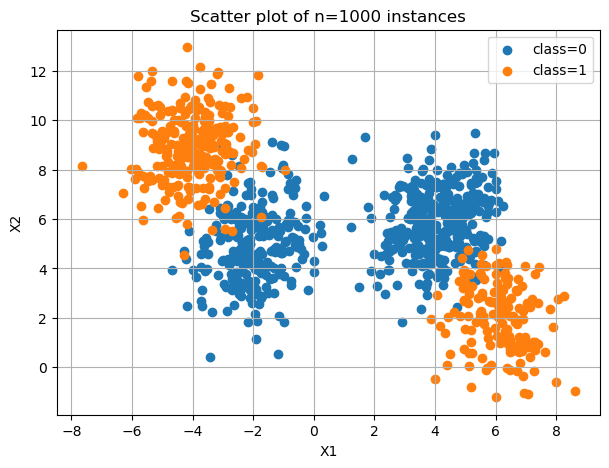

In [2]:
train_data = pd.read_csv('train_data_shuffled.csv')
test_data = pd.read_csv('test_data_shuffled.csv')
X_train, y_train = train_data[['x1', 'x2']].values, train_data['y'].values
X_test, y_test = test_data[['x1', 'x2']].values, test_data['y'].values

# plot scatter plot of the training data
classes = np.unique(y_train)
n_samples = 1000
# set seed for reproducibility
np.random.seed(42)
random_indices = np.random.choice(len(X_train), n_samples, replace=False)
X_smp = X_train[random_indices, :]
y_smp = y_train[random_indices]

plt.figure(figsize=(7, 5))
for i in range(len(classes)):
    data = X_smp[y_smp == classes[i]]
    plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

plt.title(f'Scatter plot of n={n_samples} instances')
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid()
plt.show()


**Stop and think:** 
* What is the expected accuracy of the best linear SVM on such data? 
* What is the expected accuracy of a Naive Bayes classifier using GMMs?

## 2. SVM with hinge loss (25 points)


Implement the function `compute_hinge_loss_gradients` in the `LinearSVM` class in `hw6.py`.

The `LinearSVM` class implements a linear SVM classifier (without kernel). It finds the classifier's weights by minimzing the hinge loss using (sub)gradient descent. The hinge loss is defined as follows:
$$
L(w,w_0;D) ~=~ \frac 12 \|w\|^2 + \frac{C}{n}\sum_{i=1}^n \max\left\{\ 0\ ;\ 1-y^{(i)}\left(w^\top x^{(i)} + w_0\right)\ \right\}~.
$$

The hyperparameter $C$ controls the slackness (sensitivity to violation of margin constraints and classification errors).

The following methods are already implemented in the `LinearSVM` class:
* `predict_raw`: computes "raw predictions" before thresholding: $w^\top x^{(i)} + w_0$ for $i=1\ldots n$
* `predict`: computes predicted class labels 
$\hat{y}^{(i)}=\begin{cases} 1,~~ \text{if}\ w^\top x^{(i)} + w_0 >= 0\\ 0,~~ \text{otherwise}\end{cases}$
for $i=1\ldots n$.
* `fit`: fits model parameters. $w,w_0$ by minimizing the hinge loss using gradient descent.

Function `compute_hinge_loss_gradients`, which you are required to implement,
computes the hinge loss (before udpates) and the gradient of the hinge loss.
The gradient is specified using an array of length $p$ (`dw`) and a scalar for the bias term (`dw0`).
This function is called by the function `fit` as part of the gradient descent optimization procedure.

You may implement additional auxiliary functions, as needed, but do not change the code of the methods already implemented.

In [3]:
from hw6 import LinearSVM
# test lor class on all the data
svm = LinearSVM(C=1, max_iter=100000, learning_rate=0.01)
svm.fit(X_train, y_train, verbose=True)

y_hat_train = svm.predict(X_train)
y_hat_test = svm.predict(X_test)

train_acc = np.mean(y_hat_train.ravel() == y_train.ravel())
test_acc = np.mean(y_hat_test.ravel() == y_test.ravel())

print(f"SVM train set accuracy: {train_acc:.4f}")
print(f"SVM test set accuracy: {test_acc:.4f}")

Iteration 100: Loss = 0.860716
Iteration 200: Loss = 0.853072
Iteration 300: Loss = 0.845920
Iteration 400: Loss = 0.839329
Iteration 500: Loss = 0.833136
Iteration 600: Loss = 0.827332
Iteration 700: Loss = 0.821918
Iteration 800: Loss = 0.816960
Iteration 900: Loss = 0.812408
Iteration 1000: Loss = 0.808250
Iteration 1100: Loss = 0.804530
Iteration 1200: Loss = 0.801133
Iteration 1300: Loss = 0.798018
Iteration 1400: Loss = 0.795189
Iteration 1500: Loss = 0.792650
Iteration 1600: Loss = 0.790372
Iteration 1700: Loss = 0.788311
Iteration 1800: Loss = 0.786402
Iteration 1900: Loss = 0.784698
Iteration 2000: Loss = 0.783101
Iteration 2100: Loss = 0.781612
Iteration 2200: Loss = 0.780219
Iteration 2300: Loss = 0.778933
Iteration 2400: Loss = 0.777733
Iteration 2500: Loss = 0.776645
Iteration 2600: Loss = 0.775650
Iteration 2700: Loss = 0.774731
Iteration 2800: Loss = 0.773897
Iteration 2900: Loss = 0.773106
Iteration 3000: Loss = 0.772356
Iteration 3100: Loss = 0.771676
Iteration 3200: L

## 3. Set slackness using cross validation (10 points)

We now use 5-fold cross validation (CV) to find a good value for the slackness parameter $C$.

Implement the function `cross_validation` in `hw6.py`. 

This function starts by creating a randomly shuffled copy of the dataset and then 
it splits the shuffled copy into `n_folds` blocks of identical size  (this part is already implemented).
Your implementation should then use this split to implement m-fold cross validation with `n_fold` folds,
by fitting `n_folds` different versions of the model and computing their accuracy on a different validation block.
The function returns the average prediction accuracy across of these models.

The function receives a `classifier` object as parameter to use for fitting and evaluation.
This object should have methods `fit` and `predict` implemented (as in the `LinearSVM` class).
Since the `fit` method may modify the object, you should create a copy of the object for each fold using the `copy.deepcopy` function.

The code block below uses 5-fold CV to evaluate different vlaues of the slackness hyperparameter ($C$) in the linear SVM.
It then selects a value for $C$ that results in maximum CV accuracy.

In [4]:
from hw6 import cross_validation
from hw6 import LinearSVM

C_vals = [0.01, 0.1, 1, 10, 20]
folds = 5

random_state = 1
acc_dict = {}
for C in C_vals:
    svm = LinearSVM(C=C, max_iter=100000)
    acc = cross_validation(X_train, y_train, folds, svm, random_state=random_state)
    acc_dict[C] = acc
    print(f"Accuracy with C={C}:  {acc:.6f}")

best_params = max(acc_dict, key=acc_dict.get)

Accuracy with C=0.01:  0.400000
Accuracy with C=0.1:  0.600000
Accuracy with C=1:  0.822000
Accuracy with C=10:  0.606500
Accuracy with C=20:  0.599500


In [5]:
print(f"Best slackness parameter: C={best_params}")

best_acc = acc_dict[best_params]
print(f"Accuracy with the best parameters: {best_acc:.4f}")

Best slackness parameter: C=1
Accuracy with the best parameters: 0.8220


## 4. Normal distribution and Gaussian mixture model (GMM) (10 points)

We wish to comapre the SVM you trained above with a Naive Bayes classifier based on Gaussian mixture models (GMM). For this purporse, we first have to implement functions for computing the relevant densities.

Implement the functions `norm_pdf` and `gmm_pdf` in `hw6.py`. 

Function `norm_pdf` computes the probability density of a normal distribution with given parameters (`mu` and `sigma`) on a vector of real values (`x`).
Function `gmm_pdf`  computes the probability density of a GMM with given parameters on a vector of real values (`x`).
Here the parameters are: `weights` (the probability vector $\pi$ for the different Gaussians), `mus` (the means of the different Gaussians) and `sigmas` (the standard deviations of the different Gaussians).

The code block below computes the PDF of a GMM with three mixture components.

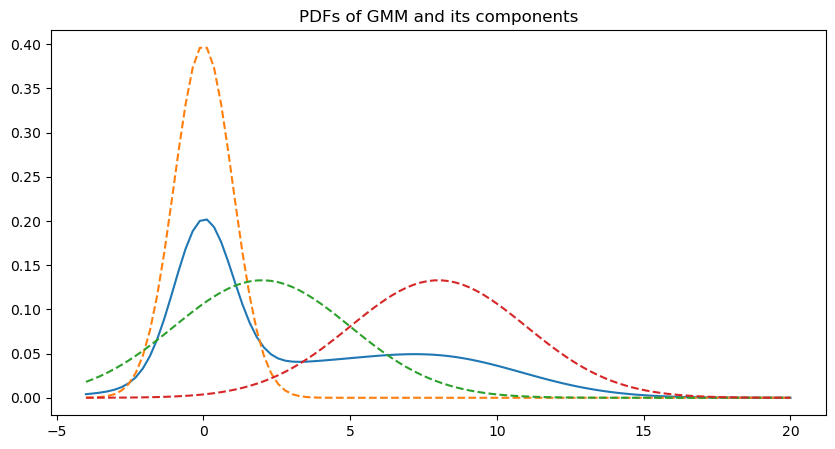

In [6]:
from hw6 import norm_pdf, gmm_pdf

#  parameters for a gmm
mus = [0, 2, 8]
sigmas =  [1 , 3,  3]
weights = [0.4, 0.2, 0.3]
weights = weights / np.sum(weights)

# generate a grid of points for plotting the pdf
# the grid should cover the range of the GMM
xx = np.linspace(mus[0]-4*sigmas[0], mus[2]+4*sigmas[2], 100)

# plot the PDF of the GMM and its components
plt.figure(figsize=(10, 5))
plt.plot(xx, gmm_pdf(xx, weights, mus, sigmas), label='GMM')
for i in range(len(mus)):
    plt.plot(xx, norm_pdf(xx, mus[i], sigmas[i]), label=f'Gaussian {i+1}', linestyle='--')
plt.title('PDFs of GMM and its components')

plt.show()

## 5. Fit a GMM via Expectation Maximization (EM) (35 points)

Implement the class `GMM` in `hw6.py`. 

This class implements an EM algorithm for fitting a one-dimensional (univariate) GMM to a single feature of the data (the feature's marginal distribution).
Your class should contain the following functions:
1. `get_dist_params` - returns a dictionary with the GMM parameters (already implemented; do not modify)
1. `init_params` - initializes distribution params (already implemented; do not modify)
1. `fit` - learns parameters via the EM algorithm
1. `expectation` - calculates responsibilities
1. `maximization` - updates GMM parameters based on responsibilities
1. `loss` - compute the negative log likelihood (see below)
1. `pdf` - returns the PDF of the GMM in a given set of values

Implements the five methods above. You can implement additional functions or add class members, if you think it is useful.

Recall that the parameters of a GMM with $k$ one-dimensional Gaussians are:
$$
\theta = (w_1,..,w_k, \mu_1,...,\mu_k, \sigma_1,...,\sigma_k) ~,
$$
* $w_j$ is the weight of the $j$-th Gaussian in the mixture (we use $w$ here instead of $\pi$ to avoid confusion with class priors; see (6) below)
* $\mu_j$ is the mean value of the $j$-th Gaussian
* $\sigma_j$ is the standard deviation of $j$-th Gaussian

The negative log-likelihood is used as loss for training:
$$
J(x; \theta) = \sum_{j=1}^{k}-\log(w_j \cdot \mathcal{N}(x; \mu_j, \sigma_j))
$$

The code block below fits a univariate GMM to data sampled from the GMM defined in the code block above. 

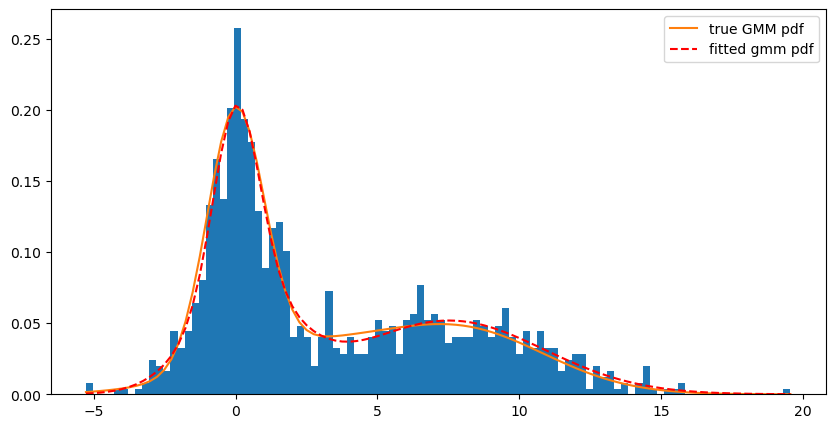

In [7]:
from hw6 import GMM

# sample (approximately) form the GMM
n_samples = 1000

k = len(mus)
x = np.zeros(n_samples)
for i in range(n_samples):
    j = np.random.choice(k, p=weights)
    xi = mus[j] + sigmas[j] * np.random.randn() 
    x[i] = xi

plt.figure(figsize=(10, 5))
plt.hist(x, bins=100, density=True)
xx = np.linspace(x.min(), x.max(), 100)
# plot the gmm pdf
plt.plot(xx, gmm_pdf(xx, weights, mus, sigmas), label='true GMM pdf')
# fit a gmm to the data
gmm = GMM(k=3, max_iter=10000)
gmm.fit(x)
plt.plot(xx, gmm.pdf(xx), '--r', label='fitted gmm pdf')
plt.legend()
plt.show()


The code block below fits four GMMs to our training data: one to each class (0,1) and each feature ($x_1,x_2$).
Each of these GMMs uses $k=2$ Gaussians.

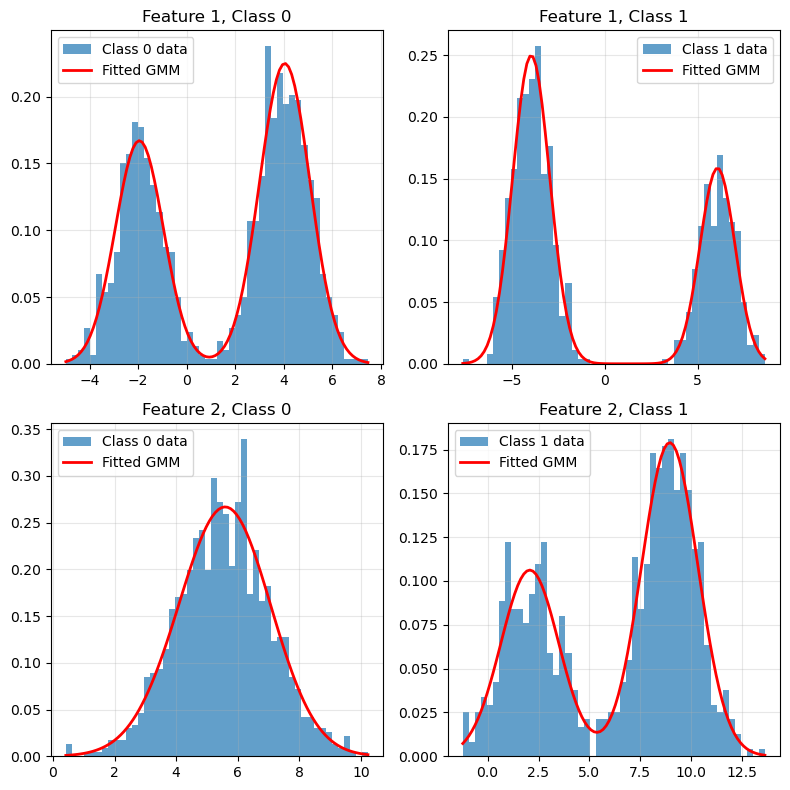

In [8]:
# now fit a GMM for every feature in every class
# Illustrate the fitted GMMs for each feature in each class over the histogram of the feature
# plot everything using a grid of n_features x n_classes :

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
K=2

# Create a grid of subplots
fig, axes = plt.subplots(n_features, n_classes, figsize=(4*n_classes, 4*n_features))

# If only one feature or one class, make axes iterable
if n_features == 1:
    axes = axes.reshape(1, -1)
if n_classes == 1:
    axes = axes.reshape(-1, 1)

# Fit GMM for each feature in each class
for feature_idx in range(n_features):
    for class_idx in range(n_classes):
        # Get data for this feature and class
        mask = (y_train == class_idx)
        feature_data = X_train[mask, feature_idx]
        
        # Fit GMM
        gmm = GMM(k=K, max_iter=1000, eps=0.01)
        gmm.fit(feature_data.reshape(-1, 1))
        
        # Plot histogram of the data
        axes[feature_idx, class_idx].hist(feature_data, bins=50, density=True, alpha=0.7, 
                                         label=f'Class {class_idx} data')
        
        # Plot fitted GMM PDF
        xx = np.linspace(feature_data.min(), feature_data.max(), 100)
        axes[feature_idx, class_idx].plot(xx, gmm.pdf(xx), 'r-', linewidth=2, 
                                         label=f'Fitted GMM')
        
        axes[feature_idx, class_idx].set_title(f'Feature {feature_idx+1}, Class {class_idx}')
        axes[feature_idx, class_idx].legend()
        axes[feature_idx, class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. GMM naive Bayes classifier (20 points)

Implement the class `NaiveBayesGMM` in `hw6.py`. 

This class implements a Naive Bayes classifier which fits a GMM to each (class,feature) combination.
Your class should contain the following functions:
1. `fit` - trains the model by fitting all GMMs using `GMM` objects, as you implemented in (5) above
1. `predict` - provides predictions for a given set of samples

Implements the two methods above. You can implement additional functions or add class members, if you think it is useful.

The GMM Naive Bayes classifier should predict classes based on the following MAP rule:
$$
\hat{y} = \argmax_j \left\{\pi_j\prod_{t=1}^p GMM_{j,t}(x_t) \right\} ~,
$$
where $GMM_{j,t}$ is the PDF of the GMM of class $j$ and feature $t$.

The code block below trains a GMM Naive Bayes classifier on the trianing data and tests it on the test data.

In [9]:
from hw6 import NaiveBayesGMM

# train a GMM Naive Bayes Classifier
naive_byes = NaiveBayesGMM(k=2)
naive_byes.fit(X_train, y_train)

# evaluate on training and test sets
y_hat_train = naive_byes.predict(X_train)
y_hat_test = naive_byes.predict(X_test)
train_acc = np.mean(y_hat_train.ravel() == y_train.ravel())
test_acc = np.mean(y_hat_test.ravel() == y_test.ravel())
print(f"Naive byes training set accuracy: {train_acc:.4f}")
print(f"Naive byes test set accuracy: {test_acc:.4f}")

Naive byes training set accuracy: 0.9215
Naive byes test set accuracy: 0.9010


## 7. Comparing the two classifiers (0 points)

We now train two different classifiers and compare their performance and decision boundaries.

1. A SVM classifier with the best $C$ we found earlier
1. A GMM Naive Bayes classifier in which each GMM uses a mixture of $k=2$ Gaussians.

The code block below trains the two classifiers, prints their train and test accuracies, and uses the function `plot_decision_regions` to illustrate their decision boundaries.

SVM train accuracy: 0.8195
SVM test accuracy: 0.8130
Naive Bayes train accuracy: 0.9215
Naive Bayes test accuracy: 0.9010


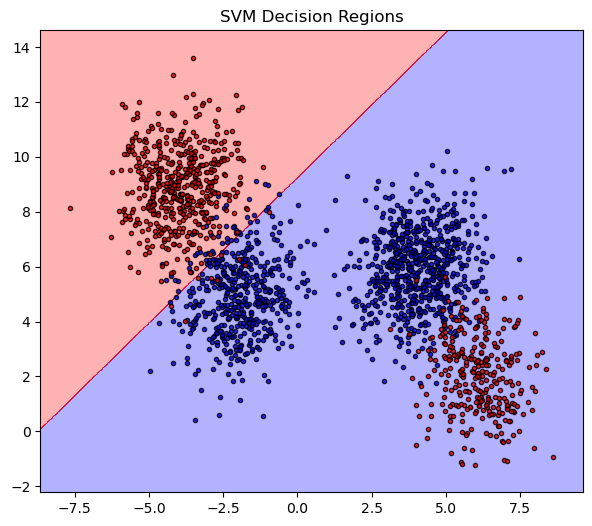

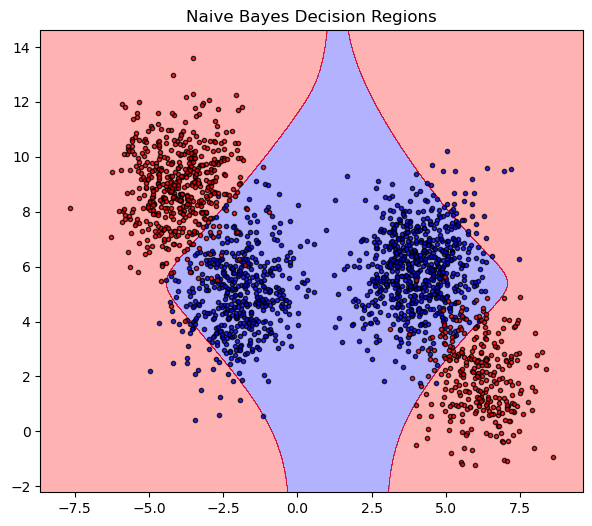

In [10]:
from hw6 import LinearSVM, NaiveBayesGMM

def model_score(X, y, cls):
    y_hat = cls.predict(X).ravel()
    return np.mean(y_hat == y.ravel())

def plot_decision_regions(X, y, classifier, resolution=0.01, title=""):
    """
    Plot the decision regions of a classifier.
    """

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.figure(figsize=(7, 6))
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.title(title)
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.show()


svm_cls = LinearSVM(C=best_params)
svm_cls.fit(X_train, y_train)
naive_bayes_cls = NaiveBayesGMM(k=2)
naive_bayes_cls.fit(X_train, y_train)

# evalaute train and test accuracy
svm_train_acc = model_score(X_train, y_train, svm_cls)
svm_test_acc = model_score(X_test, y_test, svm_cls)
naive_bayes_train_acc = model_score(X_train, y_train, naive_bayes_cls)
naive_bayes_test_acc = model_score(X_test, y_test, naive_bayes_cls)

print(f"SVM train accuracy: {svm_train_acc:.4f}")
print(f"SVM test accuracy: {svm_test_acc:.4f}")
print(f"Naive Bayes train accuracy: {naive_bayes_train_acc:.4f}")
print(f"Naive Bayes test accuracy: {naive_bayes_test_acc:.4f}")

plot_decision_regions(X_train, y_train, svm_cls, title="SVM Decision Regions")
plot_decision_regions(X_train, y_train, naive_bayes_cls, title="Naive Bayes Decision Regions")